# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total PnL')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.9350,2173.6457,1.0000,-131.8862,-11.2894,-143.1756
JASMYUSDT,387.4585,247.9264,0.1141,0.0000,-139.5321,-139.5321
ETHUSDT,250.7473,184.0665,0.0847,0.0000,-66.6808,-66.6808
BBUSDT,60.1761,33.9574,0.0156,-39.7331,-26.2186,-65.9517
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
BNBUSDT,1.1421,0.9910,0.0005,-10.6060,-0.1511,-10.7572
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,79.2639,0.0365,-10.7239,2.3950,-8.3289
XRPUSDT,0.0000,0.0000,0.0000,-6.1145,0.0000,-6.1145
MKRUSDT,0.0000,0.0000,0.0000,-6.0975,0.0000,-6.0975


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities=quantities.sort_index()
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_quantity=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_quantity.index=pd.to_datetime(price_quantity.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_quantity[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total'][4:]

2024-09-27   -131.886217
2024-09-28   -131.886217
2024-09-29   -131.886217
2024-09-30   -131.886217
2024-10-01   -131.886217
2024-10-02   -131.886217
2024-10-03   -131.886217
2024-10-04   -131.886217
2024-10-05   -131.886217
2024-10-06   -131.886217
2024-10-07   -337.500769
2024-10-08   -344.180408
2024-10-09   -375.615395
2024-10-10   -347.926055
2024-10-11   -302.956679
2024-10-12   -276.666978
2024-10-13   -265.907701
2024-10-14   -142.332259
2024-10-15   -163.448396
2024-10-16   -168.424332
2024-10-17   -183.334771
2024-10-18   -176.385224
2024-10-19   -180.957063
2024-10-20   -143.937680
2024-10-21   -186.314601
2024-10-22   -201.935715
2024-10-23   -250.904729
2024-10-24   -234.108305
2024-10-25   -339.306249
2024-10-26   -322.303981
2024-10-27   -200.301397
2024-10-28   -222.114486
2024-10-29   -159.909168
2024-10-30   -155.100477
2024-10-31   -224.945662
2024-11-01   -224.730511
2024-11-02   -255.691112
2024-11-03   -293.511531
2024-11-04   -354.928333
2024-11-05   -295.444499


In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

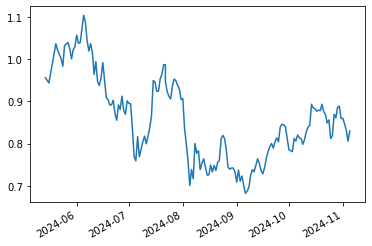

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APEUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.001},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3450
TRXUSDT,0.3171
BNBUSDT,0.2108
PEPEUSDT,0.0481
RAYUSDT,0.0413
SUIUSDT,0.0356
USDCUSDT,0.0010
FDUSDUSDT,0.0010
JASMYUSDT,0.0000
PENDLEUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.407292
BTCUSDT,0.300000
BNBUSDT,0.109081
TRXUSDT,0.081054
RAYUSDT,0.044027
PEPEUSDT,0.033747
SUIUSDT,0.024799


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.769046
OMUSDT,0.230954


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,659.095017,0.303221,0.000000,0.000000
OMUSDT,635.824252,0.292515,0.230954,0.061561
SOLUSDT,332.521093,0.152978,0.000000,0.000000
JASMYUSDT,247.926437,0.114060,0.000000,0.000000
ETHUSDT,184.066515,0.084681,0.000000,0.000000
TRXUSDT,79.263917,0.036466,0.769046,-0.732580
BBUSDT,33.957437,0.015622,0.000000,0.000000
BNBUSDT,0.991008,0.000456,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,659.095017,0.303221,0.300000,0.003221
OMUSDT,635.824252,0.292515,0.407292,-0.114777
SOLUSDT,332.521093,0.152978,0.000000,0.000000
JASMYUSDT,247.926437,0.114060,0.000000,0.000000
ETHUSDT,184.066515,0.084681,0.000000,0.000000
TRXUSDT,79.263917,0.036466,0.081054,-0.044588
BBUSDT,33.957437,0.015622,0.000000,0.000000
BNBUSDT,0.991008,0.000456,0.109081,-0.108625
PEPEUSDT,0.000002,0.000000,0.033747,-0.033747
RAYUSDT,0.000000,0.000000,0.044027,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

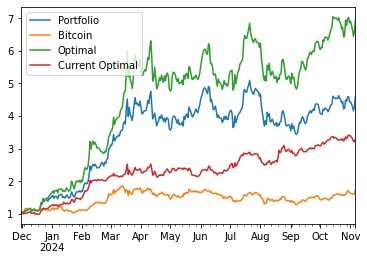

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

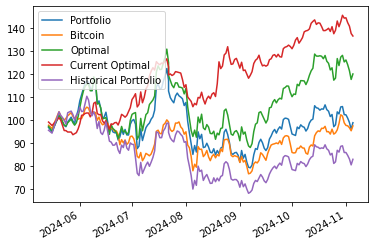

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-27,103.577068,95.800103,126.723557,143.012204,86.923713
2024-10-28,102.702447,98.494813,123.671724,140.533566,86.118716
2024-10-29,105.722018,102.324979,127.339286,142.690862,88.647197
2024-10-30,105.905137,101.772478,128.118476,145.503588,88.861818
2024-10-31,102.398127,98.842997,125.246540,144.268267,85.953443
2024-11-01,102.313295,97.717294,126.105972,144.408790,85.974244
2024-11-02,100.861190,97.546629,124.039198,142.287842,84.703394
2024-11-03,98.983791,96.701083,121.455436,140.771886,83.138049
2024-11-04,95.979590,95.390284,117.661896,137.566063,80.587176
2024-11-05,98.900517,97.506416,120.037015,136.499795,83.011146


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.62358
 dtype: float64,
 0.6244693558496448)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.512502
 dtype: float64,
 0.5125015589931478)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.577762
Bitcoin            0.432421
Optimal            0.624469
Current Optimal    0.381108
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2405263817191301

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.130867,0.109081,0.022857,0.039965,0.006838,0.033127
BTCUSDT,0.221907,0.300000,0.049716,0.133834,0.043155,0.090679
OMUSDT,8.873597,0.407292,0.884076,0.727128,0.615076,0.112052
PEPEUSDT,0.071878,0.033747,0.010062,0.030836,0.004556,0.026280
RAYUSDT,0.133262,0.044027,0.016888,0.042837,0.006796,0.036041
SUIUSDT,0.026407,0.024799,0.004878,0.013412,0.001440,0.011971
TRXUSDT,0.039919,0.081054,0.011524,0.011989,0.001406,0.010583


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.126006,0.230954,0.268405,0.431007,0.373373,0.057633
TRXUSDT,0.203927,0.769046,0.731595,0.568993,0.511360,0.057633


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.036038,0.303030,0.290079,0.202364,0.056421,0.145943
OMUSDT,0.159819,0.292929,0.387335,0.374465,0.213056,0.161409
SOLUSDT,0.013449,0.151515,0.141130,0.158552,0.036576,0.121976
JASMYUSDT,-0.023466,0.111111,0.074982,0.158396,0.039860,0.118536
ETHUSDT,-0.014742,0.080808,0.056521,0.065958,0.006914,0.059044
TRXUSDT,0.010714,0.040404,0.043732,0.006110,0.000501,0.005609
BBUSDT,-0.012932,0.020202,0.006220,0.034155,0.002685,0.031471


# Value At Risk

## Historical

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05095569469207801, -0.07474407197477465)

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04935919489937786, -0.06541153690207331)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012938
OMUSDT      -0.018743
SOLUSDT     -0.004521
JASMYUSDT   -0.006013
ETHUSDT     -0.006208
TRXUSDT      0.000289
BBUSDT      -0.000889
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049023
Name: 2024-08-04 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.013141
OMUSDT      -0.021807
SOLUSDT     -0.010932
JASMYUSDT   -0.010495
ETHUSDT     -0.004801
TRXUSDT     -0.000657
BBUSDT      -0.001940
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.063773
dtype: float64

## Parametric

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06470504115999924, -0.0829339728140423)

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.053103381548797374, -0.06806385287371214)

## Multivariate

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05776127113098581, -0.07446525583867776)

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.052270243341713374, -0.06718288945038253)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.011574
OMUSDT      -0.017432
SOLUSDT     -0.008701
JASMYUSDT   -0.007964
ETHUSDT     -0.003563
TRXUSDT     -0.000177
BBUSDT      -0.002077
Portfolio   -0.051488
dtype: float64

## Copulas

### Gaussian Copula

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0590914961689092, -0.07497590487877742)

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05088925899913825, -0.06365878878389233)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010780
OMUSDT      -0.017458
SOLUSDT     -0.008266
JASMYUSDT   -0.008670
ETHUSDT     -0.003906
TRXUSDT     -0.000246
BBUSDT      -0.002150
Portfolio   -0.051475
dtype: float64

### Student Copula

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05845528736809442, -0.0749785376787853)

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05288280391106134, -0.06721537636615439)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010463
OMUSDT      -0.019496
SOLUSDT     -0.008082
JASMYUSDT   -0.008636
ETHUSDT     -0.003670
TRXUSDT     -0.000300
BBUSDT      -0.001949
Portfolio   -0.052595
dtype: float64

### Gumbel Copula

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11019892874677735, -0.15658304766206235)

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06555589678961302, -0.08870414095316635)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010768
OMUSDT      -0.039930
SOLUSDT     -0.004615
JASMYUSDT   -0.007057
ETHUSDT     -0.002719
TRXUSDT      0.000088
BBUSDT      -0.000888
Portfolio   -0.065889
dtype: float64

### Monte Carlo

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06662406943420453, -0.08258087405002508)

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05344222866096377, -0.06769059483908454)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.010502
OMUSDT      -0.020722
SOLUSDT     -0.008675
JASMYUSDT   -0.008280
ETHUSDT     -0.003490
TRXUSDT     -0.000358
BBUSDT      -0.001875
Portfolio   -0.053903
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057194,-0.101263,-0.087006,-0.021460
2024-01-15,-0.057194,-0.101262,-0.085313,0.016135
2024-01-16,-0.057194,-0.101101,-0.082049,0.048545
2024-01-17,-0.057194,-0.102658,-0.086010,-0.024628
2024-01-18,-0.057194,-0.104689,-0.087946,-0.032148
...,...,...,...,...
2024-11-02,-0.037979,-0.054409,-0.051174,-0.016389
2024-11-03,-0.037979,-0.053024,-0.049222,-0.020830
2024-11-04,-0.040053,-0.054788,-0.053751,-0.031234
2024-11-05,-0.040053,-0.054832,-0.053733,0.020186


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031231,-0.084185,-0.078047,-0.016644
2024-05-29,-0.027816,-0.081348,-0.074839,-0.009867
2024-05-30,-0.027816,-0.069601,-0.062494,0.031207
2024-05-31,-0.027816,-0.068654,-0.063518,0.025181
2024-06-01,-0.027816,-0.069664,-0.061542,0.040187
...,...,...,...,...
2024-11-02,-0.049074,-0.060565,-0.063185,-0.014193
2024-11-03,-0.049074,-0.061340,-0.063858,-0.018614
2024-11-04,-0.049074,-0.061707,-0.067306,-0.030350
2024-11-05,-0.049074,-0.064896,-0.068527,0.030433


<AxesSubplot:>

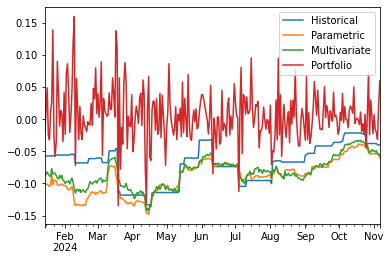

In [79]:
var_data.plot()

<AxesSubplot:>

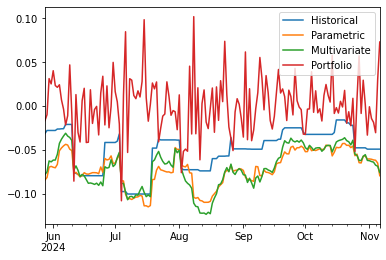

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020134,0.010067,0.010067
Kupiec Stat,7.161687,14.676853,14.676853
P-value,0.007448,0.000128,0.000128


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.07362,0.018405,0.018405
Kupiec Stat,1.681854,4.472977,4.472977
P-value,0.194678,0.034435,0.034435


## Principal Component Analysis

### Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79525254, 0.06498007, 0.05390965, 0.04447165, 0.04138609])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.014975
ADAUSDT      0.014506
ALGOUSDT     0.016015
APEUSDT      0.018075
APTUSDT      0.015668
               ...   
WBETHUSDT    0.012320
WBTCUSDT     0.010090
WLDUSDT      0.022164
XLMUSDT      0.009492
XRPUSDT      0.009248
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

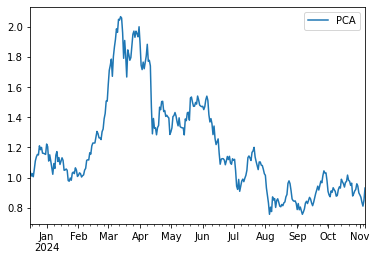

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

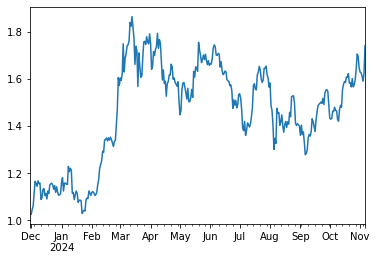

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.357469
ALGOUSDT     0.358384
ETHUSDT      0.366258
WBETHUSDT    0.366363
               ...   
RAYUSDT      0.989046
PEPEUSDT     1.015401
FLOKIUSDT    1.022594
WLDUSDT      1.073943
OMUSDT       1.337330
Length: 64, dtype: float64

<AxesSubplot:>

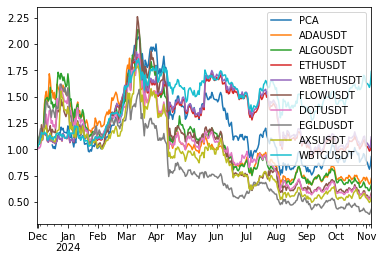

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

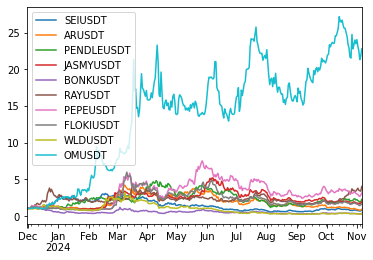

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.68211485, 0.13059812, 0.09000681, 0.06525238, 0.03202784])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.066117
OMUSDT       0.095590
SOLUSDT      0.107183
JASMYUSDT    0.156204
ETHUSDT      0.088537
TRXUSDT      0.014175
BBUSDT       0.234795
BNBUSDT      0.067173
PEPEUSDT     0.170227
Name: PC1, dtype: float64

<AxesSubplot:>

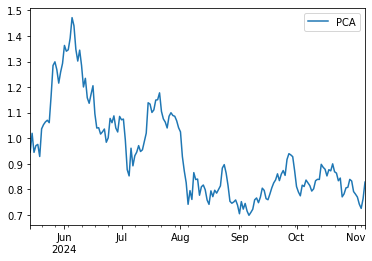

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

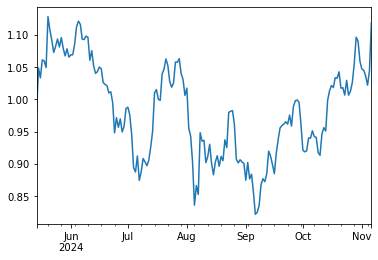

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.344402
SOLUSDT      0.354917
BTCUSDT      0.382891
BNBUSDT      0.390204
JASMYUSDT    0.431867
PEPEUSDT     0.487526
TRXUSDT      0.586350
OMUSDT       0.589893
BBUSDT       0.646911
dtype: float64

<AxesSubplot:>

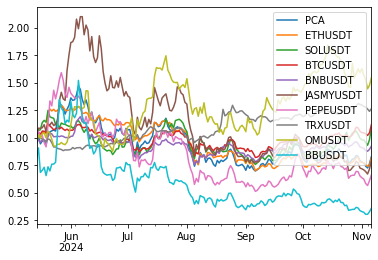

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.938410
BBUSDT       1.637088
JASMYUSDT    1.314418
SOLUSDT      1.175767
BTCUSDT      1.000000
ETHUSDT      0.968593
OMUSDT       0.948097
BNBUSDT      0.674424
TRXUSDT      0.268862
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.843326
JASMYUSDT    1.829266
PEPEUSDT     1.771385
SOLUSDT      1.383318
ETHUSDT      1.229262
BTCUSDT      1.000000
OMUSDT       0.733718
BNBUSDT      0.684333
TRXUSDT      0.271889
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.000000,0.625881,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.000000,0.182521,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.414537,0.133222,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926689,0.000000,0.073311,0.000000
2024-09-02,0.000000,0.435173,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.287486,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.000000,0.176595,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451


In [99]:
results={}
window=14
days=90
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APEUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,...,TIAUSDT,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT
2024-08-22,0.055425,0.005631,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.458079,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2024-09-05,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2024-09-19,0.189719,0.019275,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.091112
2024-10-03,0.000000,0.000000,0.0,0.000000,0.049307,0.0,0.0,0.0,0.0,0.0,...,0.0,0.494145,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2024-10-17,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.358627,0.039005,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2024-10-31,0.000000,0.000000,0.0,0.004576,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.702918,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2024-11-06,0.000000,0.000004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [100]:
rolling_optimization.iloc[-3].sort_values(ascending=False)

TRXUSDT     0.358627
LTCUSDT     0.223917
OMUSDT      0.205182
DOGEUSDT    0.145416
UNIUSDT     0.039005
              ...   
GALAUSDT    0.000000
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
XRPUSDT     0.000000
Name: 2024-10-17 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

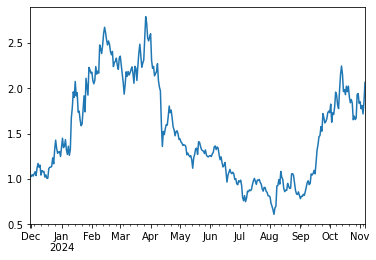

In [101]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()